贝叶斯神经网络---基于随机梯度下降，不含数据预处理，初步测试用，3.25
---

In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
import theano
from theano import shared
floatX = theano.config.floatX
import pandas as pd
from matplotlib import gridspec
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split

import scipy as sp
from theano.compile.ops import as_op
from numpy import arange, array, empty
from Plot_raw import *
from DataSplit import *
%matplotlib inline

D:\Softwares\Python\Python_Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
D:\Softwares\Python\Python_Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


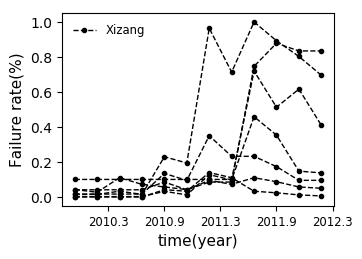

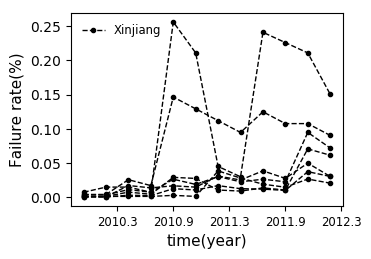

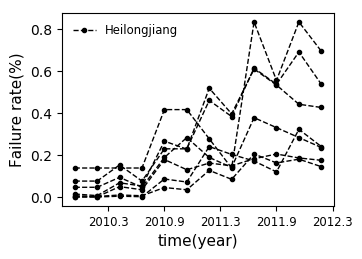

(216, 3)
3


In [10]:
np.set_printoptions(precision=0, suppress=True)
Savefig = 0 # 控制图形显示存储
plt.style.use('default')
elec_data = pd.read_csv('XZnozero_12.csv')

# 计算同一公司产品测试地点数目：
companies_num = elec_data.counts.unique()
companies = len(companies_num)  # companies=7， 共7个测试地点
company_lookup = dict(zip(companies_num, range(len(companies_num))))
company = elec_data['company_code'] = elec_data.counts.replace(company_lookup).values  # 加一行数据在XZsingal文件中

# 计算不同公司数目
company_ABC = elec_data.company.unique()
companiesABC = len(company_ABC)  # companies=7， 共7个测试地点
company_lookup_ABC = dict(zip(company_ABC, range(len(company_ABC))))
companyABC = elec_data['company_ABC'] = elec_data.company.replace(company_lookup_ABC).values  # 加一行数据在XZsingal文件中
# elec_count = elec_data.counts.values
# print(companyABC)
# print(companiesABC)
# 给所有特征因素加上高斯噪声
SNR = np.random.normal(0, 1, size=[len(elec_data.Year.values), 3])

# #特征因素分析
elec_tem = elec_data.Tem.values # 观测温度值x2，温度不加噪声
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values + SNR[:, 0]  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values + SNR[:, 1] # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
elec_Lux = elec_data.Lux.values + SNR[:, 2] # 观测压强x3
elec_Lux1 = (elec_Lux - np.mean(elec_Lux)) / np.std(elec_Lux)

# 计算观测时间，温度，光照等环境条件
elec_year = elec_data.Year.values  # 观测时间值x1
elec_year1 = (elec_year - np.mean(elec_year)) / np.std(elec_year)
# data_cs_year = np.ma.masked_values(elec_year, value=-999)
# print(data_cs_year)

elec_Pca = np.vstack((elec_tem1, elec_hPa1, elec_RH1, elec_Lux1)).T   # 特征数据合并为一个数组
# np.savetxt('XZ_nomean.csv', elec_Pca2, delimiter = ',')
# =============================================================================================
# # PCA特征降维，减少相关性，有两种方法，一种是自带函数，一种是网上程序，下面注释为网上程序
# x, z= pcaa(elec_Pca);  XX = np.array(x); ZZ = np.array(z)
# 将温度等4个特征降维变成2个特征，贡献率为99%以上，满足信息要求; 转换后的特征经过模型后能否还原
# =============================================================================================
# #白化，使得每个特征具有相同的方差，减少数据相关性，n_components：控制特征量个数
pca = PCA(n_components=2)
pca.fit(elec_Pca)
# 将数据X转换成降维后的数据。当模型训练好后，对于新输入的数据，都可以用transform方法来降维。
elec_Pca1 = pca.transform(elec_Pca)
elec_Pca1 = np.array(elec_Pca1)

elec_Pca_char1 = elec_Pca1[:, 0] # 降维特征1
elec_Pca_char2 = elec_Pca1[:, 1] # 降维特征2
print('\n')

# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大100倍以增加实际效果，结果中要缩小100倍
elec_faults = 1*(elec_data.Fault.values / elec_data.Nums.values)  # 数组形式,计算故障率大小
elec_faults_Max = np.max(elec_faults)
elec_faults = elec_faults/elec_faults_Max #最大值限定到[0,1]之间

# 将故障率以6组一行形式组成数组,变成：21*6
elec_faults2 = np.array([elec_faults[i*12:(i+1)*12] for i in np.arange(21)])
elec_year2 = np.array([elec_year[i*12:(i+1)*12] for i in np.arange(21)])
elec_char1 = np.array([elec_Pca_char1[i*12:(i+1)*12] for i in np.arange(21)])
elec_char2 = np.array([elec_Pca_char2[i*12:(i+1)*12] for i in np.arange(21)])
companyABC2 = np.array([companyABC[i*12:(i+1)*12] for i in np.arange(21)])

Plot_raw(elec_year2, elec_faults2, Savefig)
# 共享变量设置
# xs_char1 = shared(np.asarray(elec_Pca_char1))
# xs_char2 = shared(np.asarray(elec_Pca_char2))

X = scale(np.vstack((elec_year, elec_tem, elec_RH)).T)
# X = scale(elec_year) #scale用于归一化
X = X.astype(floatX)
# Y = scale(Y)
Y = elec_faults.astype(floatX)

# np.savetxt('Y_ALL.csv', Y, delimiter = ',')

X_train, X_test, Y_train, Y_test = DataSplit(X, Y, test_size=.1)

ann_output = shared(np.asarray(Y_train))
ann_input = shared(np.asarray(X_train))
# Num_shared = shared(np.asarray(companyABC))
# print(Y_test)
# print(X)
# print(Num_shared)
print(np.shape(X_train))
print(X.shape[1])
# print(X.shape[0])

In [ ]:
total_size = len(Y_train)
n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX) #X.shape[1]表示列数，X.shape[0]表示行数
init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_out = np.random.randn(n_hidden).astype(floatX)

def build_network(ann_input, ann_output):
    with pm.Model() as model:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=100,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=100,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=100,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        
#         act_out = pm.Deterministic('act_out', pm.math.sigmoid(pm.math.dot(act_2, weights_2_out)))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))
        out = pm.Poisson('out',
                           mu = act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return model, out

In [11]:
from six.moves import zip

def train_sgfs(model, B=None):

    # Tensors and RV that will be using mini-batches
    minibatch_tensors = [ann_input, ann_output]
    minibatch_RVs = [out]

    # Generator that returns mini-batches in each iteration
    def create_minibatch(data):
        rng = np.random.RandomState(0)

        while True:
            # Return random data samples of set size 50 each iteration
            ixs = rng.randint(len(data), size=20)
            yield data[ixs]

    minibatches = zip(
        create_minibatch(X_train),
        create_minibatch(Y_train),
    )

    total_size = len(Y_train)

    with model:
        draws = 4500
        step_method = pm.SGFS(batch_size=20,
                              total_size=total_size,
                              B=B,
                              step_size=.1,
                              step_size_decay=100,
                              minibatches=minibatches,
                              minibatch_tensors=minibatch_tensors)
        trace = pm.sample(draws=draws, step=step_method)
        return step_method, trace

neural_network, out = build_network(ann_input, ann_output)
%time step_method, trace = train_sgfs(neural_network)

D:\Softwares\Python\Python_Anaconda\lib\site-packages\pymc3\step_methods\sgmcmc.py:110: UserWarning: Warning: Stochastic Gradient based sampling methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 186.92it/s]


Wall time: 29.9 s


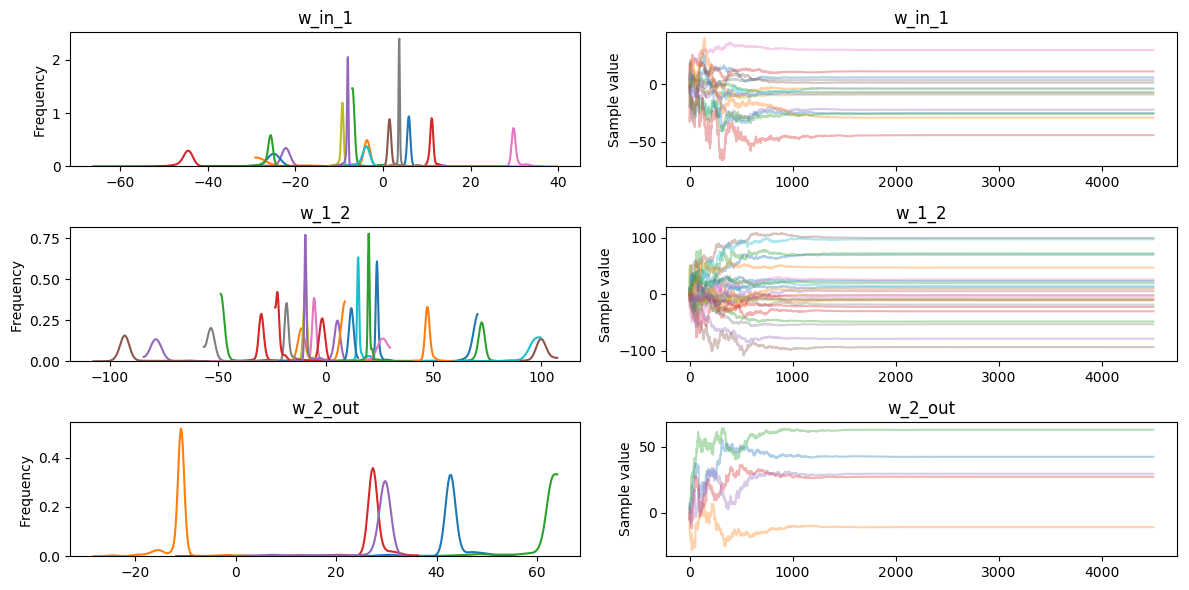

In [12]:
pm.traceplot(trace)
plt.show()

In [14]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
# ppc = pm.sample_ppc(trace, model=neural_network, samples=500, random_seed=0)
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0)
print(pred)
print(np.shape(pred))
print(np.shape(Y_test))
Pred_Mean = np.array([pred[i*12:(i+1)*12] for i in np.arange(3)])
Pred_Mean = Pred_Mean.mean(axis=0)
print(Pred_Mean)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 3114.89it/s]


[0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
(36,)
(36,)
[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]


In [7]:
# 后验分析
# varnames2 = ['act_out']
# tmp = pm.df_summary(trace, varnames2)
# betaMAP = tmp['mean'][np.arange(12)]
# print(tmp)

KeyError: 'act_out'

ValueError: x and y must have same first dimension, but have shapes (12,) and (0,)

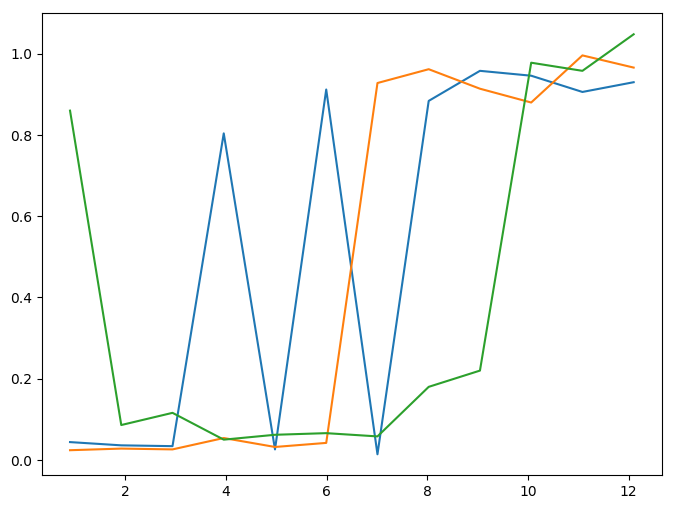

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(0.9, 12.1, 12)
for i in np.arange(6):
    ax.plot(x_plot, pred[(i*12):12*(i+1)], label="Spline estimate")

ax.legend()
plt.show()

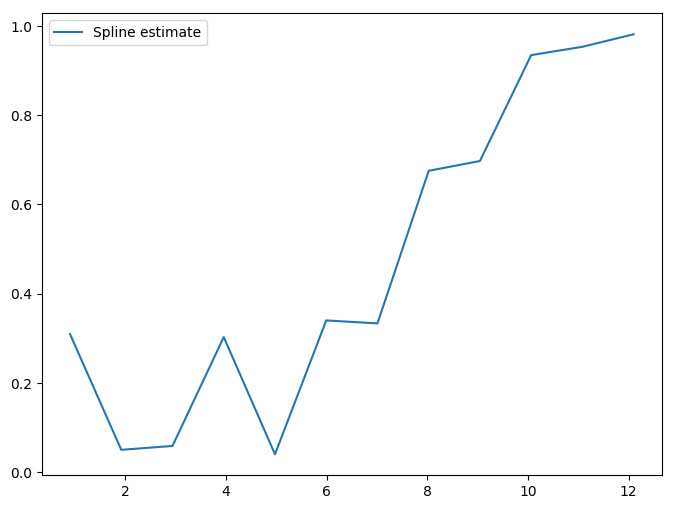

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
x_plot = np.linspace(0.9, 12.1, 12)

ax.plot(x_plot, Pred_Mean, label="Spline estimate")

ax.legend()